In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import HydroErr

from matplotlib import pyplot as plt

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 5

N_CATCHMENTS = 531

# training hyperparameters
EPOCHS = 500
TRAIN_YEAR = 14
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
study = joblib.load("data/531_nldas_original_lstm_study.pkl")

In [4]:
dtrain_val = dataloader.Forcing_Data(
    "data/531_nldas_original_camels_train_val.csv",
    record_length=5478,
    n_feature=FORCING_DIM,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtrain = dataloader.Forcing_Data(
    "data/531_nldas_original_camels_train.csv",
    record_length=4017,
    n_feature=FORCING_DIM,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = dataloader.Forcing_Data(
    "data/531_nldas_original_camels_val.csv",
    record_length=1826,
    n_feature=FORCING_DIM,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "data/531_nldas_original_camels_test.csv",
    record_length=5844,
    n_feature=FORCING_DIM,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [5]:
def get_optimal_epochs(study):
    
    stats = study.best_trials[0].intermediate_values
    epochs = min(stats, key=lambda k: stats[k]) + 1
    
    return epochs

In [6]:
def get_final_model(study, dataset, n_catchments =N_CATCHMENTS, epoch_scale = 10/TRAIN_YEAR): #19/39

    trial = study.best_trial

    # define model
    model_builder = training_fun.LSTM_model_builder(
        n_catchments, base_length=365, forcing_dim=FORCING_DIM
    )

    embedding, decoder = model_builder.define_model(trial)

    embedding, decoder = embedding.to(computing_device), decoder.to(
        computing_device
    )

    if compile_model:
        # pytorch2.0 new feature, complile model for fast training
        embedding, decoder = torch.compile(embedding), torch.compile(decoder)


    # define model training hyperparameters
    # define optimizers
    lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

    lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
    batch_size = 2**batch_size_power

    # define optimal epochs
    epochs = round(get_optimal_epochs(study)*epoch_scale)

        # steps per epoch
    steps = round(N_CATCHMENTS * TRAIN_YEAR / batch_size)

        # train model
    for epoch in range(epochs):

        # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
        # repeat TRAIN_YEAR times to finish an epoch
        decoder.train()
        embedding.train()

        for step in range(steps):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            # get training batch and pass to device
            (x_batch, y_batch, selected_catchments) = dataset.get_random_batch(
                batch_size
            )

            x_batch, y_batch, selected_catchments = (
                x_batch.to(computing_device),
                y_batch.to(computing_device),
                selected_catchments.to(computing_device),
            )

            # slice batch for training
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                code = embedding(selected_catchments)

                # pass through decoder
                out = decoder.decode(code, x_batch)

                # compute loss
                loss = training_fun.mse_loss_with_nans(out, y_batch)

            scaler.scale(loss).backward()
            scaler.step(embedding_optimizer)
            scaler.step(decoder_optimizer)
            scaler.update()

    return embedding, decoder

In [7]:
embedding, decoder = get_final_model(study, dtrain_val)

In [8]:
torch.save(embedding.cpu(), "data/531_nldas_camles_final_lstm_embedding.pt")
torch.save(decoder.cpu(), "data/531_nldas_camels_final_lstm_decoder.pt")

# Evaluation

In [9]:
embedding = torch.load("data/531_nldas_camles_final_lstm_embedding.pt").to(computing_device)
decoder = torch.load("data/531_nldas_camels_final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [10]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [11]:
x_batch_test, y_batch_test = dtest.get_val_batch()
x_batch_test.shape, y_batch_test.shape

(torch.Size([16, 531, 730, 5]), torch.Size([16, 531, 365]))

In [12]:
def eval_catchment(selected_catchment):
    
    x = x_batch_test[:,selected_catchment,:,:]
    y = y_batch_test[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn_kge = Objective_builder(x,y,HydroErr.kge_2009)
    fn_nse = Objective_builder(x,y,HydroErr.nse)
    
    kge = fn_kge.eval(catchment_embeddings[selected_catchment,:].cpu().detach().numpy())
    nse = fn_nse.eval(catchment_embeddings[selected_catchment,:].cpu().detach().numpy())
    
    return  kge, nse

In [13]:
calibrated_KGES = np.ones(N_CATCHMENTS)
calibrated_NSES = np.ones(N_CATCHMENTS)


for i in range(N_CATCHMENTS):
    #print(f'i={i} starts')
    calibrated_KGES[i], calibrated_NSES[i]  = eval_catchment(i)
    #print(f'fit={calibrated_KGES[i]}')

c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [5479 5480 5481 5482 5483 5484 5485 5486 5487 5488 5489 5490 5491 5492
 5493 5494 5495 5496 5497 5498 5499 5500 5501 5502 5503 5504 5505 5506
 5507 5508 5509 5510 5511 5512 5513 5514 5515 5516 5517 5518 5519 5520
 5521 5522 5523 5524 5525 5526 5527 5528 5529 5530 5531 5532 5533 5534
 5535 5536 5537 5538 5539 5540 5541 5542 5543 5544 5545 5546 5547 5548
 5549 5550 5551 5552 5553 5554 5555 5556 5557 5558 5559 5560 5561 5562
 5563 5564 5565 5566 5567 5568 5569 5570 5571 5572 5573 5574 5575 5576
 5577 5578 5579 5580 5581 5582 5583 5584 5585 5586 5587 5588 5589 5590
 5591 5592 5593 5594 5595 5596 5597 5598 5599 5600 5601 5602 5603 5604
 5605 5606 5607 5608 5609 5610 5611 5612 5613 5614 5615 5616 5617 5618
 5619 5620 5621 5622 5623 5624 5625 5626 5627 5628 5629 5630 5631 5632
 5633 5634 5635 5636 5637 5638 5639 5640 5641 5642 5643 5644 5645 5646
 5647 5648 5649 5650 5651 5652 5653 5654 5

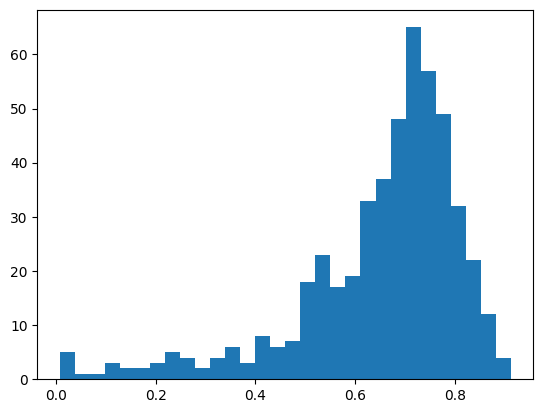

In [14]:
from matplotlib import pyplot as plt

plt.hist(calibrated_NSES[calibrated_NSES>0], bins = 30)
plt.show()

In [15]:
np.median(calibrated_KGES),calibrated_KGES.mean()

(0.6945471218645058, 0.5047193609812083)

In [16]:
np.median(calibrated_NSES),calibrated_NSES.mean()

(0.6882016956806183, 0.4921213486240633)